# MapReduce using SPARK

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


# Table of Contents

* [SPARK](#SPARK)
    * Installing Spark locally
* [Spark Context](#Spark-Context)
    * [Create A RDD](#Create-A-RDD)
    * [Call `collect` on an RDD: Lazy Spark](#Call-collect-on-an-RDD:-Lazy-Spark)
    * [Operations on RDDs](#Operations-on-RDDs)
    * [Word Examples](#Word-Examples)
    * [Key Value Pairs](#Key-Value-Pairs)
    * [word count 1](#word-count-1)
    * [word count 2:  `reduceByKey()`](#word-count-2:--reduceByKey%28%29)
    * [Nested Syntax](#Nested-Syntax)
    * [Using Cache](#Using-Cache)
    * [Fun with words](#Fun-with-words)
    * [DataFrames](#DataFrames)
    * [Machine Learning](#Machine-Learning)


With shameless stealing of some code and text from:

- https://github.com/tdhopper/rta-pyspark-presentation/blob/master/slides.ipynb
- Databricks and Berkeley Spark MOOC: https://www.edx.org/course/introduction-big-data-apache-spark-uc-berkeleyx-cs100-1x

which you should go check out.

## Installing Spark locally


**Step 1: Install Apache Spark**

For example, for Mac users using Homebrew:

```
$ brew install apache-spark
```

**Step 2: Install the Java SDK version 1.8 or above for your platform (not just the JRE runtime)**

Make sure you can access commands such as `java` on your command line.

**Step 3: Install the latest findspark package using pip**

```
➜  ~  pip install findspark
Collecting findspark
  Downloading findspark-0.0.5-py2.py3-none-any.whl
Installing collected packages: findspark
Successfully installed findspark-0.0.5
```

# Spark Context

You can also use it directly from the notebook interface on the mac if you installed `apache-spark` using `brew` and also installed `findspark` above.

In [2]:
import findspark
findspark.init('C:/Users/Benilicious/spark/spark')
import pyspark
sc = pyspark.SparkContext()

It also outputs a bunch of stuff on my terminal. This is because the entire java context is started up.

```Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
15/10/21 14:46:15 INFO SparkContext: Running Spark version 1.4.0
2015-10-21 14:46:15.774 java[30685:c003] Unable to load realm info from SCDynamicStore
15/10/21 14:46:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/10/21 14:46:15 INFO SecurityManager: Changing view acls to: rahul
15/10/21 14:46:15 INFO SecurityManager: Changing modify acls to: rahul
15/10/21 14:46:15 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: Set(rahul); users with modify permissions: Set(rahul)
15/10/21 14:46:16 INFO Slf4jLogger: Slf4jLogger started
15/10/21 14:46:16 INFO Remoting: Starting remoting
15/10/21 14:46:16 INFO Remoting: Remoting started; listening on addresses :[akka.tcp://sparkDriver@10.251.101.163:64359]
15/10/21 14:46:16 INFO Utils: Successfully started service 'sparkDriver' on port 64359.
15/10/21 14:46:16 INFO SparkEnv: Registering MapOutputTracker
15/10/21 14:46:16 INFO SparkEnv: Registering BlockManagerMaster
15/10/21 14:46:16 INFO DiskBlockManager: Created local directory at /private/var/folders/_f/y76rs29s3c57ykwyz9c8z12c0000gn/T/spark-00a4e09e-e5db-485f-81dc-2e5016e9a27e/blockmgr-8966e07c-223b-4c38-9273-11543aa9d3c1
15/10/21 14:46:16 INFO MemoryStore: MemoryStore started with capacity 273.0 MB
15/10/21 14:46:16 INFO HttpFileServer: HTTP File server directory is /private/var/folders/_f/y76rs29s3c57ykwyz9c8z12c0000gn/T/spark-00a4e09e-e5db-485f-81dc-2e5016e9a27e/httpd-6af0a9e0-1cfe-42c4-a1bd-e01715b98436
15/10/21 14:46:16 INFO HttpServer: Starting HTTP Server
15/10/21 14:46:17 INFO Utils: Successfully started service 'HTTP file server' on port 64360.
15/10/21 14:46:17 INFO SparkEnv: Registering OutputCommitCoordinator
15/10/21 14:46:18 INFO Utils: Successfully started service 'SparkUI' on port 4040.
15/10/21 14:46:18 INFO SparkUI: Started SparkUI at http://10.251.101.163:4040
15/10/21 14:46:18 INFO Executor: Starting executor ID driver on host localhost
15/10/21 14:46:18 INFO Utils: Successfully started service 'org.apache.spark.network.netty.NettyBlockTransferService' on port 64361.
15/10/21 14:46:18 INFO NettyBlockTransferService: Server created on 64361
15/10/21 14:46:18 INFO BlockManagerMaster: Trying to register BlockManager
15/10/21 14:46:18 INFO BlockManagerMasterEndpoint: Registering block manager localhost:64361 with 273.0 MB RAM, BlockManagerId(driver, localhost, 64361)
15/10/21 14:46:18 INFO BlockManagerMaster: Registered BlockManager
```

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

### Create A RDD


In [5]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print (type(wordsRDD))

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

Spark is lazy. Until you `collect`, nothing is actually run.

>Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program.

In [6]:
wordsRDD.collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

```
15/10/21 14:59:59 INFO SparkContext: Starting job: collect at <ipython-input-6-dee494da0714>:1
15/10/21 14:59:59 INFO DAGScheduler: Got job 0 (collect at <ipython-input-6-dee494da0714>:1) with 4 output partitions (allowLocal=false)
15/10/21 14:59:59 INFO DAGScheduler: Final stage: ResultStage 0(collect at <ipython-input-6-dee494da0714>:1)
15/10/21 14:59:59 INFO DAGScheduler: Parents of final stage: List()
15/10/21 14:59:59 INFO DAGScheduler: Missing parents: List()
15/10/21 14:59:59 INFO DAGScheduler: Submitting ResultStage 0 (ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:396), which has no missing parents
15/10/21 15:00:00 INFO MemoryStore: ensureFreeSpace(1224) called with curMem=0, maxMem=286300569
15/10/21 15:00:00 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 1224.0 B, free 273.0 MB)
15/10/21 15:00:00 INFO MemoryStore: ensureFreeSpace(777) called with curMem=1224, maxMem=286300569
15/10/21 15:00:00 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 777.0 B, free 273.0 MB)
15/10/21 15:00:00 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on localhost:64361 (size: 777.0 B, free: 273.0 MB)
15/10/21 15:00:00 INFO SparkContext: Created broadcast 0 from broadcast at DAGScheduler.scala:874
15/10/21 15:00:00 INFO DAGScheduler: Submitting 4 missing tasks from ResultStage 0 (ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:396)
15/10/21 15:00:00 INFO TaskSchedulerImpl: Adding task set 0.0 with 4 tasks
15/10/21 15:00:00 INFO TaskSetManager: Starting task 0.0 in stage 0.0 (TID 0, localhost, PROCESS_LOCAL, 1379 bytes)
15/10/21 15:00:00 INFO TaskSetManager: Starting task 1.0 in stage 0.0 (TID 1, localhost, PROCESS_LOCAL, 1384 bytes)
15/10/21 15:00:00 INFO TaskSetManager: Starting task 2.0 in stage 0.0 (TID 2, localhost, PROCESS_LOCAL, 1379 bytes)
15/10/21 15:00:00 INFO TaskSetManager: Starting task 3.0 in stage 0.0 (TID 3, localhost, PROCESS_LOCAL, 1403 bytes)
15/10/21 15:00:00 INFO Executor: Running task 0.0 in stage 0.0 (TID 0)
15/10/21 15:00:00 INFO Executor: Running task 2.0 in stage 0.0 (TID 2)
15/10/21 15:00:00 INFO Executor: Running task 1.0 in stage 0.0 (TID 1)
15/10/21 15:00:00 INFO Executor: Running task 3.0 in stage 0.0 (TID 3)
15/10/21 15:00:00 INFO Executor: Finished task 1.0 in stage 0.0 (TID 1). 646 bytes result sent to driver
15/10/21 15:00:00 INFO Executor: Finished task 3.0 in stage 0.0 (TID 3). 665 bytes result sent to driver
15/10/21 15:00:00 INFO Executor: Finished task 0.0 in stage 0.0 (TID 0). 641 bytes result sent to driver
15/10/21 15:00:00 INFO Executor: Finished task 2.0 in stage 0.0 (TID 2). 641 bytes result sent to driver
15/10/21 15:00:00 INFO TaskSetManager: Finished task 1.0 in stage 0.0 (TID 1) in 61 ms on localhost (1/4)
15/10/21 15:00:00 INFO TaskSetManager: Finished task 3.0 in stage 0.0 (TID 3) in 60 ms on localhost (2/4)
15/10/21 15:00:00 INFO TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 96 ms on localhost (3/4)
15/10/21 15:00:00 INFO TaskSetManager: Finished task 2.0 in stage 0.0 (TID 2) in 63 ms on localhost (4/4)
15/10/21 15:00:00 INFO DAGScheduler: ResultStage 0 (collect at <ipython-input-6-dee494da0714>:1) finished in 0.120 s
15/10/21 15:00:00 INFO TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool
15/10/21 15:00:00 INFO DAGScheduler: Job 0 finished: collect at <ipython-input-6-dee494da0714>:1, took 0.872367 s
```

### Operations on RDDs

From the Spark Programming Guide:

>RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

### Word Examples

In [7]:
def makePlural(word):
    return word + 's'

print (makePlural('cat'))

cats


Transform one RDD into another.

In [8]:
pluralRDD = wordsRDD.map(makePlural)
print (pluralRDD.first())
print (pluralRDD.take(2))


cats
['cats', 'elephants']


In [9]:
pluralRDD.take(1)

['cats']

In [10]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

### Key Value Pairs

In [11]:
wordPairs = wordsRDD.map(lambda w: (w, 1))
print( wordPairs.collect())

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


```
➜  sparklect  ps auxwww | grep pyspark
rahul           30685   0.4  0.8  3458120  68712 s012  S+    2:46PM   2:00.21 /System/Library/Java/JavaVirtualMachines/1.6.0.jdk/Contents/Home/bin/java -cp /usr/local/opt/apache-spark/libexec/conf/:/usr/local/opt/apache-spark/libexec/lib/spark-assembly-1.4.0-hadoop2.6.0.jar:/usr/local/opt/apache-spark/libexec/lib/datanucleus-api-jdo-3.2.6.jar:/usr/local/opt/apache-spark/libexec/lib/datanucleus-core-3.2.10.jar:/usr/local/opt/apache-spark/libexec/lib/datanucleus-rdbms-3.2.9.jar -Xms512m -Xmx512m -XX:MaxPermSize=128m org.apache.spark.deploy.SparkSubmit pyspark-shell
rahul           31520   0.0  0.0  2432784    480 s011  R+    6:42PM   0:00.00 grep --color=auto --exclude-dir=.bzr --exclude-dir=.cvs --exclude-dir=.git --exclude-dir=.hg --exclude-dir=.svn pyspark
rahul           31494   0.0  0.7  2548972  57288 s012  S     6:41PM   0:00.10 python -m pyspark.daemon
rahul           31493   0.0  0.7  2548972  57308 s012  S     6:41PM   0:00.10 python -m pyspark.daemon
rahul           31492   0.0  0.7  2548972  57288 s012  S     6:41PM   0:00.11 python -m pyspark.daemon
rahul           31446   0.0  0.8  2548972  68460 s012  S     6:35PM   0:01.34 python -m pyspark.daemon
```

### WORD COUNT!

This little exercise shows how to use mapreduce to calculate the counts of individual words in a list.

In [12]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print (wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


![Tons of shuffling](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/images/reduce_by.png)

In [13]:
print ((wordsRDD
    .map(lambda w: (w, 1))
    .reduceByKey(lambda x,y: x+y)).toDebugString())

b'(4) PythonRDD[19] at RDD at PythonRDD.scala:48 []\n |  MapPartitionsRDD[18] at mapPartitions at PythonRDD.scala:122 []\n |  ShuffledRDD[17] at partitionBy at <unknown>:0 []\n +-(4) PairwiseRDD[16] at reduceByKey at <ipython-input-13-de218d677346>:3 []\n    |  PythonRDD[15] at reduceByKey at <ipython-input-13-de218d677346>:3 []\n    |  ParallelCollectionRDD[9] at parallelize at PythonRDD.scala:175 []'


### Using Cache

In [14]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
print (wordsRDD)
wordsRDD.count()

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:175


5

Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.

In [15]:
#this is rerun from the start
wordsRDD.count()

5

In [16]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:175

In [17]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [18]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So `cache` or `persist` serves as a checkpoint, breaking the RDD chain or the *lineage*.

In [19]:
birdsList=['heron','owl']
animList=wordsList+birdsList
animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birdsList:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [20]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()
#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()
#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print (mammalcount, birdcount)

5 2


In [21]:
animsrdd.filter(lambda w: animaldict[w]=='mammal').collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

### Exercises: Fun with MapReduce

Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file `./sparklect/english.stop.txt` contains a list of English stopwords, while the file `./sparklect/shakes/juliuscaesar.txt` contains the entire text of Shakespeare's 'Julius Caesar'.

* Load all of the stopwords into a Python list
* Load the text of Julius Caesar into an RDD using the `sparkcontext.textfile()` method. Call it `juliusrdd`.

In [22]:
# your turn
stop_text = open('./sparklect/english.stop.txt')
stopwords = stop_text.readlines()
stop_text.close()
juliusrdd = sc.textFile('./sparklect/shakes/juliuscaesar.txt')


In [23]:
stopwordsrdd = sc.textFile('./sparklect/english.stop.txt')
stopwords = stopwordsrdd.flatMap(lambda x: x.split()).collect()


How many words does Julius Caesar have? *Hint: use `flatMap()`*.

In [24]:
# your turn
wordcount = juliusrdd.flatMap(lambda x: x.split()).count()
print(wordcount)

21245


Now print the first 20 words of Julius Caesar as a Python list.

In [25]:
# your turn
juliuswords = juliusrdd.flatMap(lambda x: x.split()).take(20)
print(juliuswords)

['1599', 'THE', 'TRAGEDY', 'OF', 'JULIUS', 'CAESAR', 'by', 'William', 'Shakespeare', 'Dramatis', 'Personae', 'JULIUS', 'CAESAR,', 'Roman', 'statesman', 'and', 'general', 'OCTAVIUS,', 'Triumvir', 'after']


Now print the first 20 words of Julius Caesar, **after removing all the stopwords**. *Hint: use `filter()`*.

In [26]:
# your turn
juliusnostop = juliusrdd.flatMap(lambda x: x.split()).filter(lambda x: x not in stopwords).take(20)
print(juliusnostop)

['1599', 'THE', 'TRAGEDY', 'OF', 'JULIUS', 'CAESAR', 'William', 'Shakespeare', 'Dramatis', 'Personae', 'JULIUS', 'CAESAR,', 'Roman', 'statesman', 'general', 'OCTAVIUS,', 'Triumvir', "Caesar's", 'death,', 'Augustus']


Now, use the word counting MapReduce code you've seen before. Count the number of times each word occurs and print the top 20 results as a list of tuples of the form `(word, count)`. *Hint: use `takeOrdered()` instead of `take()`*

In [27]:
# your turn
juliuswordcount = (juliusrdd
                   .flatMap(lambda x: x.split())
                   .filter(lambda x: x not in stopwords)
                   .map(lambda x: (x,1))
                   .reduceByKey(lambda x,y: x + y)
                   .takeOrdered(20)
                  )
print(juliuswordcount)

[('"', 44), ('"Alas,', 1), ('"Break', 1), ('"Brutus"', 1), ('"Brutus,', 2), ('"Caesar"?', 1), ('"Caesar,', 1), ('"Caesar."', 2), ('"Darest', 1), ('"Do', 1), ('"Fly,', 1), ('"Give', 1), ('"Havoc!"', 1), ('"Help', 1), ('"Help,', 1), ('"Liberty,', 1), ('"Lo,', 1), ('"Long', 1), ('"Peace,', 1), ('"Shall', 1)]


Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

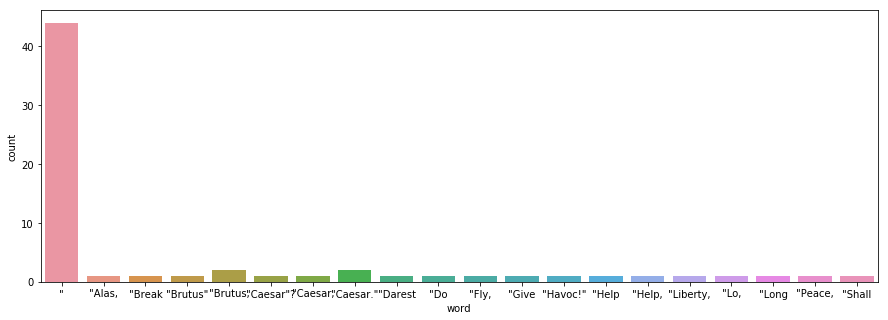

In [28]:

x = [x for x,y in juliuswordcount]
count = [y for x,y in juliuswordcount]

df=pd.DataFrame()
df['count'] = count
df['word'] = x

plt.figure(figsize=(15,5))
sns.barplot(x='word', y='count', data=df)

### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

>You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

>For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [29]:
shakesrdd=sc.textFile("./sparklect/shakes/*.txt", minPartitions=4)

In [30]:
shakesrdd.take(10)

['1601',
 'AS YOU LIKE IT',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'DRAMATIS PERSONAE.',
 '',
 '']

Now calculate the top 20 words in all of the files that you just read.

In [31]:
# your turn
shakeswordcount = (shakesrdd
                   .flatMap(lambda x: x.split())
                   .filter(lambda x: x not in stopwords)
                   .map(lambda x: (x,1))
                   .reduceByKey(lambda x,y: x + y)
                   .takeOrdered(20)
                  )
print(shakeswordcount)


[('"', 82), ('"\'Tis', 1), ('"A', 2), ('"Alas,', 1), ('"Amen"', 2), ('"Amen"?', 1), ('"Amen,"', 1), ('"And', 1), ('"Aroint', 1), ('"B', 1), ('"Black', 1), ('"Break', 1), ('"Brutus"', 1), ('"Brutus,', 2), ('"C', 1), ('"Caesar"?', 1), ('"Caesar,', 1), ('"Caesar."', 2), ('"Certes,"', 1), ('"Come', 1)]


## Optional topic 1: DataFrames

Pandas and Spark dataframes can be easily converted to each other, making it easier to work with different data formats. This section shows some examples of each.

Convert Spark DataFrame to Pandas

`pandas_df = spark_df.toPandas()`

Create a Spark DataFrame from Pandas

`spark_df = context.createDataFrame(pandas_df)`

Must fit in memory.

![](https://ogirardot.files.wordpress.com/2015/05/rdd-vs-dataframe.png?w=640&h=360)

VERY IMPORTANT: DataFrames in Spark are like RDD in the sense that they’re an immutable data structure.

In [32]:
df=pd.read_csv("sparklect/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Convert this pandas dataframe to a Spark dataframe

In [33]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)
sparkdf = sqlsc.createDataFrame(df)
sparkdf

DataFrame[Gender: string, Height: double, Weight: double]

In [34]:
sparkdf.show(5)

+------+-----------------+----------------+
|Gender|           Height|          Weight|
+------+-----------------+----------------+
|  Male|  73.847017017515|241.893563180437|
|  Male|68.78190404589029|  162.3104725213|
|  Male|74.11010539178491|  212.7408555565|
|  Male| 71.7309784033377|220.042470303077|
|  Male| 69.8817958611153|206.349800623871|
+------+-----------------+----------------+
only showing top 5 rows



In [35]:
type(sparkdf.Gender)

pyspark.sql.column.Column

In [36]:
# You can't call .map() on a DataFrame directly - you first have to convert it into an RDD
temp = sparkdf.rdd.map(lambda r: r.Gender)
print (type(temp))
temp.take(10)

<class 'pyspark.rdd.PipelinedRDD'>


['Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male']

## Optional topic 2: Machine Learning using Spark



In [37]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

Now create a data set from the Spark dataframe

In [38]:
data=sparkdf.rdd.map(lambda row: LabeledPoint(row.Gender=='Male',[row.Height, row.Weight]))
data.take(5)

[LabeledPoint(1.0, [73.8470170175,241.89356318]),
 LabeledPoint(1.0, [68.7819040459,162.310472521]),
 LabeledPoint(1.0, [74.1101053918,212.740855557]),
 LabeledPoint(1.0, [71.7309784033,220.042470303]),
 LabeledPoint(1.0, [69.8817958611,206.349800624])]

In [39]:
data2=sparkdf.rdd.map(lambda row: LabeledPoint(row[0]=='Male',row[1:]))
data2.take(1)[0].label, data2.take(1)[0].features

(1.0, DenseVector([73.847, 241.8936]))

Split the data set into training and test sets

In [40]:
train, test = data.randomSplit([0.7,0.3])
train.cache()
test.cache()

PythonRDD[67] at RDD at PythonRDD.scala:48

In [41]:
type(train)

pyspark.rdd.PipelinedRDD

Train the logistic regression model using MLIB

In [42]:
model = LogisticRegressionWithLBFGS.train(train)

In [43]:
model.weights

DenseVector([-0.4698, 0.1932])

Run it on the test data

In [44]:
results = test.map(lambda lp: (lp.label, float(model.predict(lp.features))))
print (results.take(10))
type(results)                       

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]


pyspark.rdd.PipelinedRDD

Measure accuracy and other metrics

In [45]:
test_accuracy=results.filter(lambda x: x[0]==x[1]).count()/float(results.count())
test_accuracy

0.9239960172585463

In [46]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(results)

In [47]:
print( type(metrics))
metrics.areaUnderROC

<class 'pyspark.mllib.evaluation.BinaryClassificationMetrics'>


0.9239917249401842

In [48]:
type(model)

pyspark.mllib.classification.LogisticRegressionModel

In [49]:
!rm -rf mylogistic.model

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
model.save(sc, "mylogistic.model")

The pipeline API automates a lot of this stuff, allowing us to work directly on dataframes.

Also see:

- http://jordicasanellas.weebly.com/data-science-blog/machine-learning-with-spark
- http://spark.apache.org/docs/latest/mllib-guide.html
- http://www.techpoweredmath.com/spark-dataframes-mllib-tutorial/
- http://spark.apache.org/docs/latest/api/python/
- http://spark.apache.org/docs/latest/programming-guide.html

`rdd.saveAsTextFile()` saves an RDD as a string.

## Optional Topic 3: Your Turn at Machine Learning! :)

For this exercise, we're going to use one of the datasets we've already worked with: the Boston House Prices dataset. We're going to try a couple of regression algorithms, but from the SparkML library this time.

Before you proceed, make sure to do an overview of the documentation: 
http://spark.apache.org/docs/latest/api/python/pyspark.ml.html

In [72]:
# All imports go here
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector



First, we have to load the dataset, which resides as a CSV file in the folder for this exercise.

In [90]:
# Path: /sparklect/boston.csv
boston_df = pd.read_csv("sparklect/boston.csv")
sparkboston = sqlsc.createDataFrame(boston_df)

Inspect the data to make sure everything is loaded properly.

In [93]:
bostondata = sparkboston.rdd.map(lambda row: ( row.medv, DenseVector( row[:13] ) ) )
sboston = sqlsc.createDataFrame(bostondata, ['label','features'])
sboston.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 24.0|[0.00632,18.0,2.3...|
| 21.6|[0.02731,0.0,7.07...|
| 34.7|[0.02729,0.0,7.07...|
| 33.4|[0.03236999999999...|
| 36.2|[0.06905,0.0,2.18...|
+-----+--------------------+
only showing top 5 rows



Now we'll need to create a train/test split.

In [99]:
# We'll first have to vectorize the features
boston_train, boston_test = sboston.randomSplit([0.7,0.3])
boston_train.cache()
boston_test.cache()

DataFrame[label: double, features: vector]

As the next step, fit a Linear Regression model on the training set.

In [101]:
lr = LinearRegression(featuresCol='features', labelCol='label')
model2 = lr.fit(boston_train)

Now validate the model on the test set, and check the Root Mean Squared Error.

In [109]:
predicted = model2.transform(boston_test)

predictions = predicted.select('prediction').rdd.map(lambda x: x[0])
labels = predicted.select('label').rdd.map(lambda x: x[0])

predictionandlabel = predictions.zip(labels).collect()

predictionandlabel[:5]



[(15.112221070069065, 13.1),
 (15.077346367226676, 13.5),
 (14.199606296786683, 13.9),
 (11.134475167689509, 14.4),
 (16.983854778108025, 15.2)]

In [110]:
print(model2.summary.rootMeanSquaredError, model2.summary.r2)

4.5513637438754495 0.7334783480870565


Let's compare Linear Regression with a more powerful algorithm - the Random Forest. As the Random Forest has several hyperparameters that can be tuned for maximum accuracy, we're going to need to use k-fold Cross Validation.

First, set up a grid for the hyperparameter search.

In [115]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor()

grid = ParamGridBuilder().addGrid(rf.maxDepth, [2,5,7]).addGrid(rf.numTrees, [10,15,20]).build()

Now, with a Random Forest regressor using k-fold Cross Validation, and find the optimal combination of hyperparameters.

In [117]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator()
cv = CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(boston_train)

Finally, validate the model on the test set and check the Root Mean Squared Error again.

In [124]:
rfPredicted = cvModel.transform(boston_test)

print(evaluator.evaluate(rfPredicted, {evaluator.metricName: "rmse"}),
      evaluator.evaluate(rfPredicted, {evaluator.metricName: "r2"}))

3.7266877946858568 0.8593419343439113




## Optional Topic 4: Model Your Capstone Dataset


If you have time, load up the cleaned dataset from one of your capstone projects. Do you remember which algorithm and the accompanying combination of hyperparameters did the best job? For practice, try and implement the same model in SparkML.

In [ ]:
# Stop Spark
sc.stop()